In [39]:
import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim
from models.Richard_Lucy import Richard_Lucy
from models.Tikhonet import Tikhonet
from models.Unrolled_ADMM import Unrolled_ADMM_Old, ResUNet
from utils.utils_test import PSNR, estimate_shear
from utils.utils_data import down_sample, get_flux

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
fov_pixels = 48                     # Number of pixels in FOV, the size of the image is (fov_pixels, fov_pixels).
pixel_scale = 0.2                   # Pixel scale (aresec), determines the resolution (0.2 for LSST).
upsample = 4                        # Upsample factor for the images.

psf_delta = np.zeros([fov_pixels, fov_pixels])
psf_delta[int(fov_pixels/2)-1,int(fov_pixels/2)-1] = 1

In [41]:
exp_time = 30.                      # Exposure time (2*15 seconds).
sky_brightness = 20.48              # Sky brightness (absolute magnitude) in i band.
zero_point = 27.85                  # Instrumental zero point, i.e. asolute magnitude that would produce one e- per second.
gain = 2.3                          # CCD Gain (e-/ADU).
qe = 0.94                           # CCD Quantum efficiency.
read_noise = 8.8                    # Standrad deviation of Gaussain read noise (e-/pixel).

sky_level_pixel = get_flux(ab_magnitude=sky_brightness, exp_time=exp_time, zero_point=zero_point, gain=gain, qe=qe) * pixel_scale ** 2
print('sky_level_pixel: {:.2f}'.format(sky_level_pixel))

sky_level_pixel: 349.47


In [42]:
# Initialize catalog
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/' # path to your COSMOS data.
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample="23.5")
# real_galaxy_catalog = galsim.RealGalaxyCatalog(sample="23.5")

# Pick a galaxy
gal_idx = 0 # Galaxy index in the catalog
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, index=gal_idx)
psf_hst = real_galaxy_catalog.getPSF(gal_idx)

In [43]:
random_seed = 235 # 31415
rng_base = galsim.BaseDeviate(seed=random_seed)
rng = galsim.UniformDeviate(seed=random_seed) # U(0,1).
rng_defocus = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.36) # N(0,0.36).
rng_gaussian = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.07) # N(0,0.07).
# The FWHM of the PSF, namely the atmospheric seeing.
fwhms = np.array([0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
freqs = np.array([0., 20., 17., 13., 9., 0.])
fwhm_table = galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline')
fwhms = np.linspace(fwhms[0],fwhms[-1],100) # Upsample the distribution.
freqs = np.array([fwhm_table(fwhm) for fwhm in fwhms]) / fwhm_table.integrate() # Normalization.
rng_fwhm = galsim.DistDeviate(seed=rng_base, function=galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline'))

In [44]:
# Atmospheric PSF
atmos_fwhm = 0.6 # rng_fwhm()             # Atmospheric seeing (arcsec), the FWHM of the Kolmogorov function.
atmos_e = 0.01 + 0.02 * rng()       # Ellipticity of atmospheric PSF (magnitude of the shear in the “distortion” definition), U(0.01, 0.03).
atmos_beta = 2. * np.pi * rng()     # Shear position angle (radians), N(0,2*pi).

# Optical PSF
opt_defocus = rng_defocus()         # Defocus (wavelength), N(0.0.36).
opt_a1 = rng_gaussian()             # Astigmatism (like e2) (wavelength), N(0.0.07).
opt_a2 = rng_gaussian()             # Astigmatism (like e1) (wavelength), N(0.0.07).
opt_c1 = rng_gaussian()             # Coma along y axis (wavelength), N(0.0.07).
opt_c2 = rng_gaussian()             # Coma along x axis (wavelength), N(0.0.07).
spher = rng_gaussian()              # Spherical aberration (wavelength), N(0.0.07).
trefoil1 = rng_gaussian()           # Trefoil along y axis (wavelength), N(0.0.07).
trefoil2 = rng_gaussian()           # Trefoil along x axis (wavelength), N(0.0.07).
opt_obscuration = 0.1 + 0.4 * rng() # Linear dimension of central obscuration as fraction of pupil linear dimension, U(0.1, 0.5).
lam_over_diam = .013 + 0.07 * rng() # Wavelength over diameter (arcsec), U(0.013, 0.083).

In [45]:
# Atmospheric PSF
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1)
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)

# Optical PSF
optics = galsim.OpticalPSF(lam_over_diam,
                           defocus = opt_defocus,
                           coma1 = opt_c1, coma2 = opt_c2,
                           astig1 = opt_a1, astig2 = opt_a2,
                           spher=spher, trefoil1=trefoil1, trefoil2=trefoil2,
                           obscuration = opt_obscuration,
                           flux=1)

# Convolve the two components
psf = galsim.Convolve([atmos, optics])

# Draw PSF images
# optics_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
# optics.drawImage(optics_psf_image, scale=pixel_scale/upsample, method='auto')
# atmos_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
# atmos.drawImage(atmos_psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
psf.drawImage(psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = torch.from_numpy(psf_image.array)
psf_image = torch.max(torch.zeros_like(psf_image), psf_image)

In [46]:
rng_gal_shear = galsim.DistDeviate(seed=rng, function=lambda x: x, x_min=0.01, x_max=0.05)

gal_g = rng_gal_shear()             # Shear of the galaxy (magnitude of the shear in the "reduced shear" definition), U(0.01, 0.05).
gal_beta = 2. * np.pi * rng()       # Shear position angle (radians), N(0,2*pi).
gal_mu = 1 + rng() * 0.1            # Magnification, U(1.,1.1).
theta = 2. * np.pi * rng()          # Rotation angle (radians), U(0,2*pi).
dx = 2 * rng() - 1                  # Offset along x axis, U(-1,1).
dy = 2 * rng() - 1                  # Offset along y axis, U(-1,1).

In [47]:
gal = gal_ori.rotate(theta * galsim.radians) # Rotate by a random angle
gal = gal.shear(g=gal_g, beta=gal_beta * galsim.radians) # Apply the desired shear
gal = gal.magnify(gal_mu) # Apply a magnification

# Draw galaxy image
gal_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
# try:
#     gal.drawImage(gal_image, scale=pixel_scale, offset=(dx,dy), method='auto')
# except:
gal = galsim.Convolve([psf_hst, gal]) # Convolve wth original PSF of HST to avoid FFT error
gal.drawImage(gal_image, scale=pixel_scale/upsample, offset=(dx,dy), method='auto')
gal_image = torch.from_numpy(gal_image.array)

In [48]:
def down_sample(input, rate=4):
    weight = torch.ones([1,1,rate,rate]) / (rate**2) # Average filter.
    input = input.unsqueeze(0).unsqueeze(0)
    output = F.conv2d(input=input, weight=weight, stride=rate).squeeze(0).squeeze(0)
    return output

gal_image_down = down_sample(gal_image, rate=upsample)
psf = down_sample(psf_image, rate=upsample)

In [49]:
snr_list = [40, 100, 200]
gt_list = []

sigma = np.sqrt(sky_level_pixel + 2 * (read_noise*qe/gain) ** 2)
for snr in snr_list:
    alpha = snr * sigma / torch.sqrt((gal_image_down**2).sum()) # Scale the flux of galaxy to meet SNR requirement.
    gt_list.append(gal_image * alpha)

In [50]:
conv_list = []
for i, gt in enumerate(gt_list):
    conv = ifftshift(ifft2(fft2(psf_image) * fft2(gt))).real # Convolution using FFT.
    conv = down_sample(conv)
    conv = torch.max(torch.zeros_like(conv), conv) # Set negative pixels to zero.
    conv_list.append(conv)
    gt_list[i] = down_sample(gt)

In [51]:
obs_list = []
gt_shear_list = []
gaussian_noise = torch.normal(mean=torch.zeros_like(conv), std=sigma*torch.ones_like(conv))

for gt, conv in zip(gt_list, conv_list):
    obs = conv + gaussian_noise 
    # obs = conv + torch.normal(mean=torch.zeros_like(conv), std=sigma*torch.ones_like(conv))
    # obs = torch.max(torch.zeros_like(obs), obs) # Set negative pixels to zero.
    obs_list.append((obs, estimate_shear(obs.clone().numpy())[2], PSNR(obs.numpy(),gt.numpy())))
    gt_shear_list.append(estimate_shear(gt.clone().numpy())[2])

### Richardson-Lucy

In [52]:
# n_iters = 10

# rec_RLs = []
# model = Richard_Lucy(n_iters=n_iters)
# model.to(device)
# model.eval()
# for (obs, _, _), gt in zip(obs_list, gt_list):
#     output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device)+sky_level_pixel, psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
#     rec = output.squeeze(dim=0).squeeze(dim=0).cpu().numpy() - sky_level_pixel
#     rec_shear = estimate_shear(rec)[2]
#     rec_psnr = PSNR(rec, gt.clone())
#     rec_RLs.append((rec, rec_shear, rec_psnr))

### Tikhonet and ShapeNet

In [53]:
# rec_tiks = [[], []]
# model_files = ['../saved_models/Tikhonet_Laplacian_50epochs.pth', 
#                '../saved_models/ShapeNet_Laplacian_50epochs.pth']
# for idx, model_file in enumerate(model_files):
#     model = Tikhonet(filter='Laplacian')
#     model.to(device)
#     model.eval()
#     model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
#     print(f'Successfully loaded in {model_file}.')

#     for (obs, _, _), gt in zip(obs_list, gt_list):
#         alpha = obs.mean()
#         alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

#         output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
#         rec = output.cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy()
#         rec_shear = estimate_shear(rec)[2]
#         rec_psnr = PSNR(rec, gt.clone())

#         rec_tiks[idx].append((rec, rec_shear, rec_psnr))

### Unrolled ADMM

In [54]:
iter_list = [2, 4, 8]
rec_admm = [[], [], []]
alpha_list = []
model_files = [f'../saved_models/Gaussian_PnP_ADMM_2iters_MultiScale_50epochs.pth', 
               f'../saved_models/Gaussian_PnP_ADMM_4iters_MultiScale_50epochs.pth', 
               f'../saved_models/Gaussian_PnP_ADMM_8iters_MultiScale_50epochs.pth']
for idx, (n_iters, model_file) in enumerate(zip(iter_list, model_files)):
    model = Unrolled_ADMM_Old(n_iters=n_iters, llh='Gaussian', PnP=True)
    model.to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {model_file}.')

    for (obs, _, _), gt in zip(obs_list, gt_list):
        alpha = obs.mean()
        alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

        v_list, z_list, x_list, u1_list, u2_list, alpha = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
        v_list = [(v * alpha).cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy() for v in v_list]
        z_list = [(z * alpha).cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy() for z in z_list]
        x_list = [(x * alpha).cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy() for x in x_list]
        u1_list = [(u1 * alpha).cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy() for u1 in u1_list]
        u2_list = [(u2 * alpha).cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy() for u2 in u2_list]
        alpha = alpha.cpu().squeeze(dim=0).squeeze(dim=0).squeeze(dim=0).detach().numpy()
        # if idx == 0:
        #     alpha_list.append(alpha.cpu().squeeze(dim=0).squeeze(dim=0).squeeze(dim=0).detach().numpy())
        rec_admm[idx].append((v_list, z_list, x_list, u1_list, u2_list))

Successfully loaded in ../saved_models/Gaussian_PnP_ADMM_2iters_MultiScale_50epochs.pth.
Successfully loaded in ../saved_models/Gaussian_PnP_ADMM_4iters_MultiScale_50epochs.pth.
Successfully loaded in ../saved_models/Gaussian_PnP_ADMM_8iters_MultiScale_50epochs.pth.


In [55]:
len(rec_admm[2][1])

5

### Plot Images

9 9 9
tensor(19.3444) tensor(20.0939)
13.145323 -3.7405133 -1.7624533
5.162264 0.58855695 0.61941093
2.158545 -0.27937979 -0.32022643
6.3424106 -0.9579451 -0.4962691
1.3208171 -0.83345264 -0.5910106


/tmp/ipykernel_3859272/177582965.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,11,1)


-6.8091235 -0.71005005 -0.6532109
10.781779 -0.5944746 -7.636868
-4.325156 57.72174 21.106253


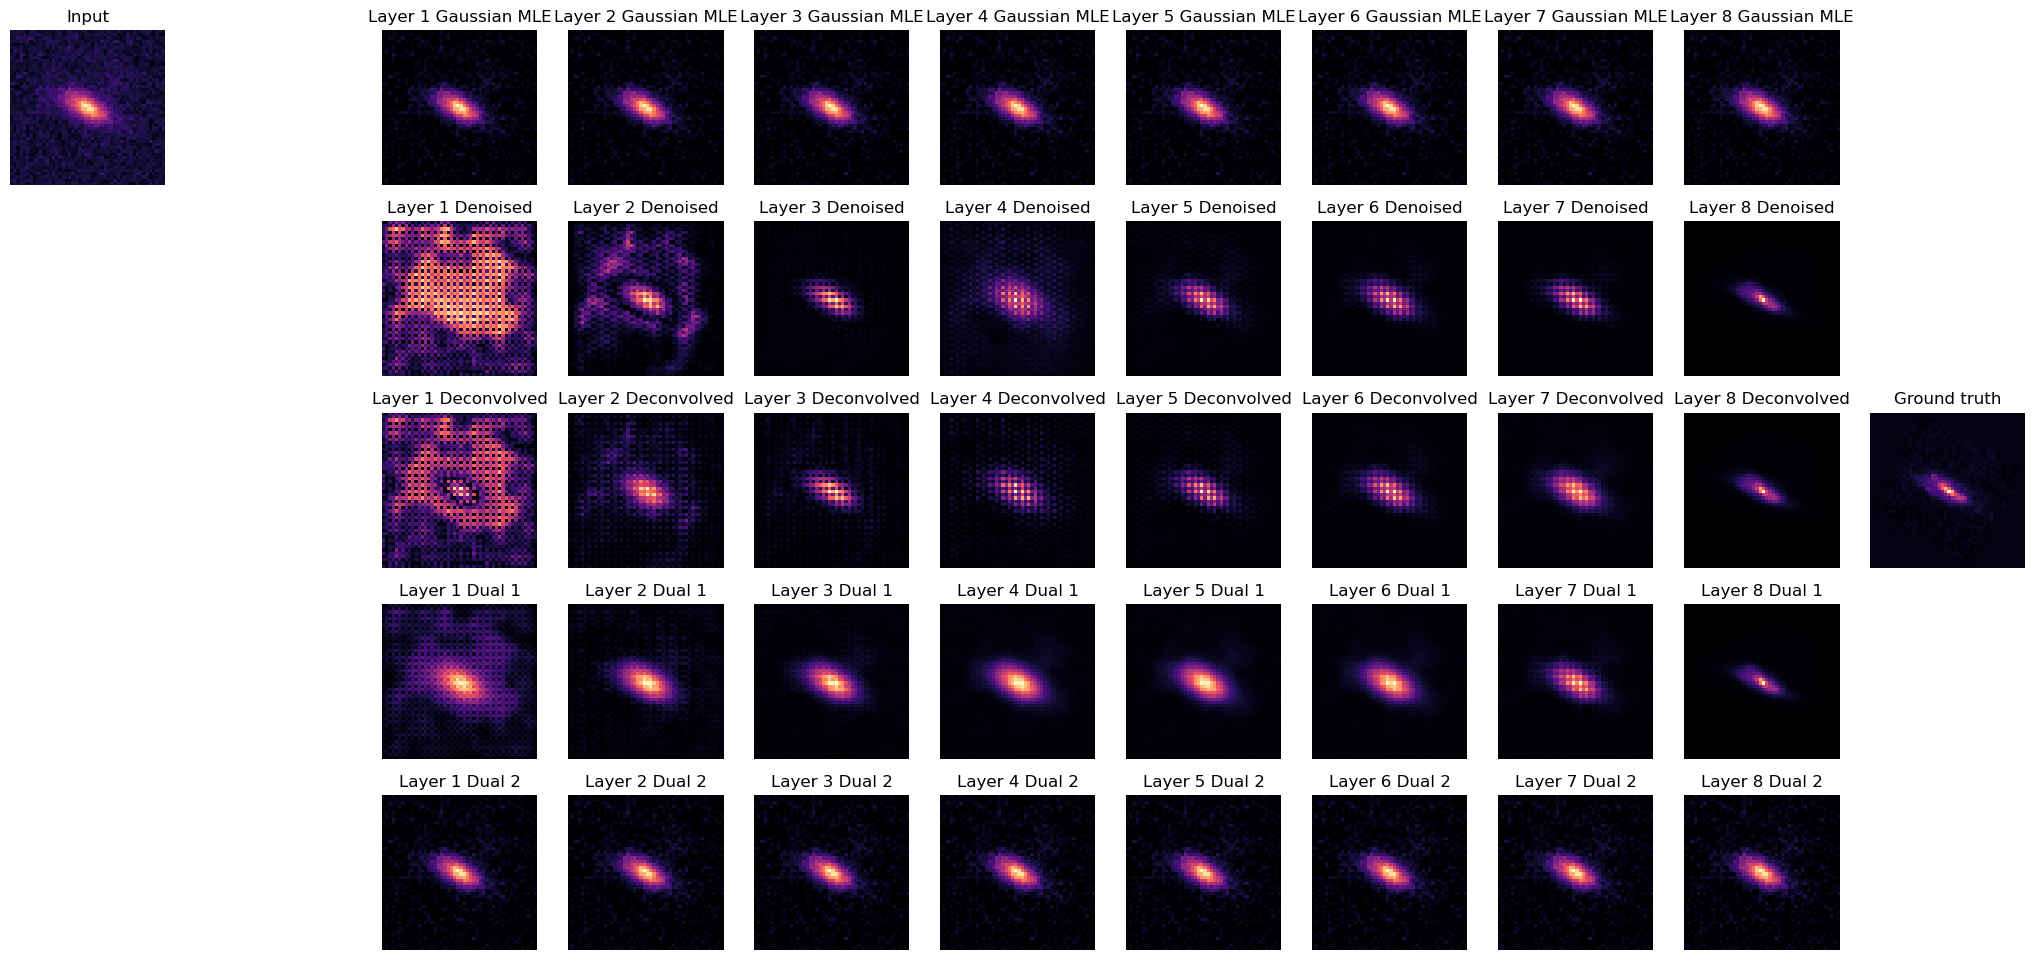

In [63]:
fig = plt.figure(figsize=(26,12), facecolor='white')
ax = plt.gca()
cmap = 'magma'

snr, gt, obs,  = snr_list[2], gt_list[2], obs_list[2]
v_list, z_list, x_list, u1_list, u2_list = rec_admm[2][2][0], rec_admm[2][2][1], rec_admm[2][2][2], rec_admm[2][2][3], rec_admm[2][2][4]
print(len(v_list), len(z_list), len(x_list))
vmax = gt.max()
vmin = gt.min()*0
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)
print(gt.mean(), obs[0].mean())
plt.subplot(5,11,1)
plt.imshow(obs[0], cmap=cmap)
plt.axis('off')
plt.title('Input')

plt.subplot(5,11,33)
plt.imshow(gt, cmap=cmap)
plt.axis('off')
plt.title('Ground truth')

for i, (v, z, x, u1, u2) in enumerate(zip(v_list, z_list, x_list, u1_list, u2_list)):
    if i == 0:
        continue
    print(v.mean(), z.mean(), x.mean())
    plt.subplot(5,11,i+2)
    plt.imshow(np.abs(v), cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i} Gaussian MLE')
    
    plt.subplot(5,11,i+13)
    plt.imshow(np.abs(z), cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i} Denoised')
    
    plt.subplot(5,11,i+24)
    plt.imshow(np.abs(x), cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i} Deconvolved')
    
    plt.subplot(5,11,i+35)
    plt.imshow(np.abs(u1), cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i} Dual 1')
    
    plt.subplot(5,11,i+46)
    plt.imshow(np.abs(u2), cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i} Dual 2')
    # plt.imsave(f'../figures/press_release/Unrolled-ADMM(8)_SNR={snr}_layer{i+1}.jpg', rec, cmap=cmap)
    


In [57]:
# fig = plt.figure(figsize=(26,8), facecolor='white')
# ax = plt.gca()
# cmap = 'magma'

# # for idx, (snr, obs, gt_shear, rec_RL, rec_tik, rec_shape, rec_2, rec_4, rec_8) in enumerate(zip(snr_list, obs_list, gt_shear_list, rec_RLs, rec_tiks[0], rec_tiks[1], rec_admm[0], rec_admm[1], rec_admm[2])):
# for idx, (snr, gt, obs, rec_2, rec_4, rec_8) in enumerate(zip(snr_list, gt_list, obs_list, rec_admm[0], rec_admm[1], rec_admm[2])):
#     vmax = np.max([obs[0].max(), (rec_8[0][-1] * rec_8[1]).max()])
#     vmin = np.min([obs[0].min(), (rec_8[0][-1] * rec_8[1]).min()])
#     norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)
    
#     # plt.imsave(f'../figures/press_release/Observation_SNR={snr}.jpg', obs[0], cmap=cmap)
#     # plt.imsave(f'../figures/press_release/RL_SNR={snr}.jpg', rec_RL[0], cmap=cmap)
#     # plt.imsave(f'../figures/press_release/Tikhonet_SNR={snr}.jpg', rec_tik[0], cmap=cmap)
#     # plt.imsave(f'../figures/press_release/ShapeNet_SNR={snr}.jpg', rec_shape[0], cmap=cmap)
#     # plt.imsave(f'../figures/press_release/Unrolled-ADMM(2)_SNR={snr}.jpg', rec_2[0], cmap=cmap)
#     plt.subplot(3,10,10*idx+1)
#     plt.imshow(obs[0], cmap=cmap)
#     plt.axis('off')
#     plt.title('Input')
    
#     plt.subplot(3,10,10*idx+10)
#     plt.imshow(gt, cmap=cmap)
#     plt.axis('off')
#     plt.title('Ground truth')
#     for i in range(8):
#         rec = rec_8[0][i+1] * rec_8[1]
#         plt.subplot(3,10,10*idx+i+2)
#         plt.imshow(np.abs(rec), cmap=cmap)
#         plt.axis('off')
#         plt.title(f'Layer {i+1}')
#         plt.imsave(f'../figures/press_release/Unrolled-ADMM(8)_SNR={snr}_layer{i+1}.jpg', rec, cmap=cmap)
        
